In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import folium
import matplotlib.cm as cm
from rasterio.transform import from_origin
import pandas as pd
from tqdm import tqdm
import matplotlib
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling, calculate_default_transform
from PIL import Image

In [2]:
def decoupe_raster(path, output_filename, haut, bas, gauche, droite) :
      #ouverture du fichier et récupération des infos
    with rasterio.open(path)  as data:
        band1 = data.read(1)
        crs= data.crs
        bounds = data.bounds
        dtype = data.dtypes[0]
        count= data.count
        no_data = data.nodata
        resolution_x = data.res[0]  
        resolution_y = data.res[1]
        transform = data.transform
        ville = band1[haut:bas, gauche:droite]

    #calcul des nouvelles bounds
        window = rasterio.windows.Window(gauche, haut, ville.shape[1], ville.shape[0]) 
        # Calculez les bounds de la sous-image  en utilisant le transform
        sub_image_bounds = rasterio.windows.bounds(window, transform=transform)  
        print(sub_image_bounds)
    #définition du nouveau transform
    top_left_x = sub_image_bounds[0]
    top_left_y = sub_image_bounds[3]
    new_transform = from_origin(top_left_x, top_left_y, resolution_x, resolution_y)
    print(new_transform)

    #enregirstement du raster découper
    with rasterio.open(output_filename, 'w', driver='GTiff', width=ville.shape[1], height=ville.shape[0], count=count, dtype=dtype, transform=new_transform, crs=crs, bounds=sub_image_bounds, nodata=no_data) as dst:
        dst.write(ville, 1)

In [4]:
def reproj(infile, outfile):
    with rasterio.open(infile) as src:
            src_transform = src.transform
            
            # open input to match
            #with rasterio.open(match) as match:
            dst_crs = 4326
                
                # calculate the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,      # input CRS
                dst_crs,    # output CRS
                src.width,   # input width
                src.height,  # input height 
                *src.bounds,  # unpacks input outer boundaries (left, bottom, right, top)
            )
    
            # set properties for output
            dst_kwargs = src.meta.copy()
            dst_kwargs.update({"crs": dst_crs,
                               "transform": dst_transform,
                               "width": dst_width,
                               "height": dst_height,
                               "nodata": 0})
            print("Coregistered to shape:", dst_height,dst_width,'\n Affine',dst_transform)
            # open output
            with rasterio.open(outfile, "w", **dst_kwargs) as dst:
                # iterate through bands and write using reproject function
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=dst_transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
        

In [5]:
reproj('raster_LH_k20.tif', 'icu_LH.tif')

Coregistered to shape: 1330 2696 
 Affine | 0.00, 0.00, 0.03|
| 0.00,-0.00, 49.59|
| 0.00, 0.00, 1.00|


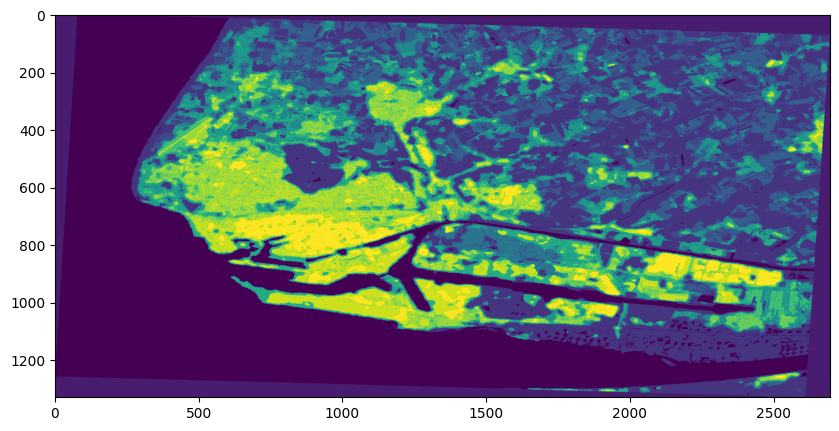

In [7]:
with rasterio.open('icu_LH.tif') as src :
    band1 = src.read(1)
    plt.figure(figsize=(10, 8))
    show(band1)

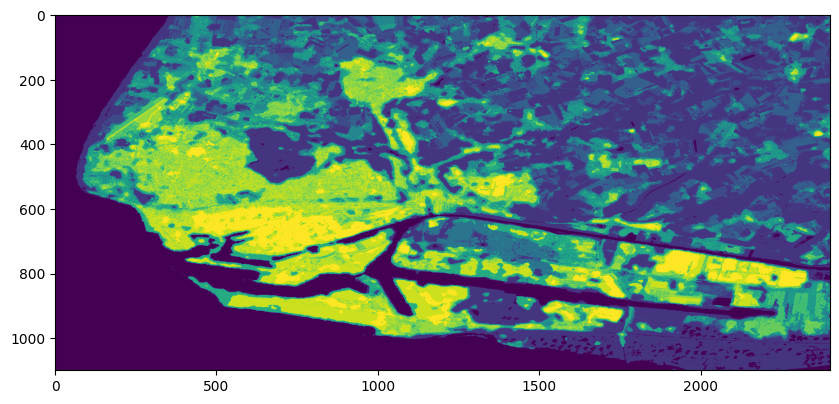

<Axes: >

In [8]:
# coordonée temp
haut = 100
bas = 1200
gauche = 200
droite = 2600
plt.figure(figsize=(10,10))
show(band1[haut:bas, gauche:droite])

In [9]:
decoupe_raster('icu_LH.tif','raster_LH_icu.tif', haut, bas, gauche, droite)

(0.058151919473254106, 49.44009785995507, 0.34938687420192965, 49.573580547539045)
| 0.00, 0.00, 0.06|
| 0.00,-0.00, 49.57|
| 0.00, 0.00, 1.00|


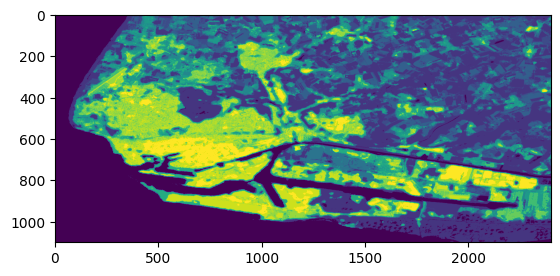

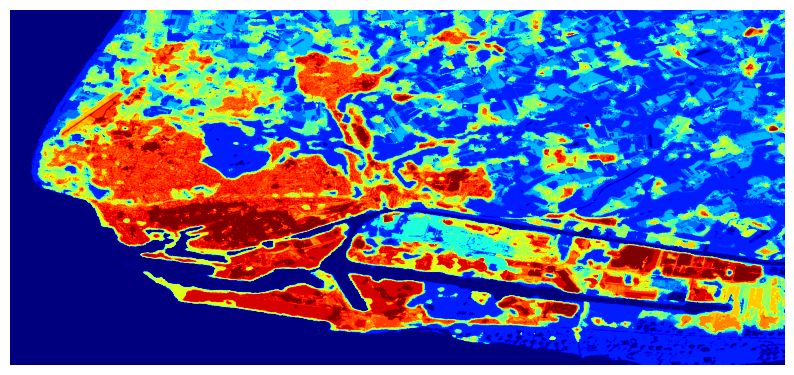

In [10]:
with rasterio.open('raster_LH_icu.tif') as src :
    band1 = src.read(1)
    show(band1)

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(band1, cmap='jet')

plt.savefig('image_jet_colormap.png', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [11]:
with rasterio.open('raster_LH_icu.tif') as data :
    bound=data.bounds
    img=data.read(1)
    print(data.meta)
    bounds = data.bounds
    print(bounds)

{'driver': 'GTiff', 'dtype': 'int64', 'nodata': 0.0, 'width': 2400, 'height': 1100, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001213478978036148, 0.0, 0.058151919473254106,
       0.0, -0.0001213478978036148, 49.573580547539045)}
BoundingBox(left=0.058151919473254106, bottom=49.44009785995507, right=0.34938687420192965, top=49.573580547539045)


In [12]:
image_path = 'image_jet_colormap.png'  # Chemin de votre image PNG
img = Image.open(image_path)

# Convertir l'image en un tableau de pixels (array)
img_array = np.array(img)

In [13]:
left = bounds[0]
right = bounds[2]
bottom = bounds[1]
top = bounds[3]

center_lat = (top + bottom) / 2
center_lon = (left + right) / 2
bounds1 = [[bottom, left], [top, right]]

# Calculer les coins supérieur gauche et inférieur droit
upper_left = [top, left]  # Coordonnées supérieures gauche
lower_right = [bottom, right]
print(bounds1)

[[49.44009785995507, 0.058151919473254106], [49.573580547539045, 0.34938687420192965]]



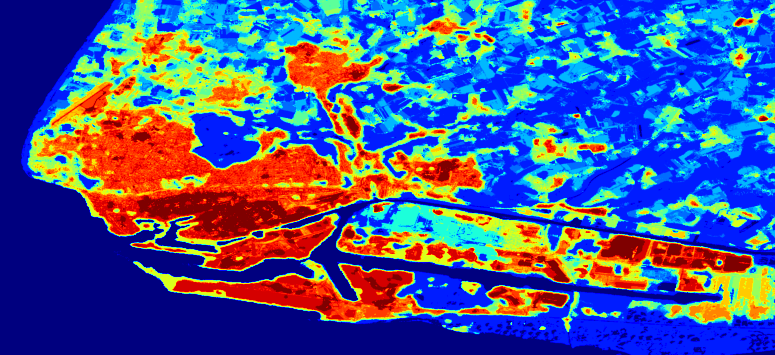

In [16]:
# Créer une carte Folium centrée sur une certaine latitude et longitude
icu_LH = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Appliquer la colormap à l'image
# color_palet = plt.jet()
# img_colormap = color_palet(img)


folium.raster_layers.ImageOverlay(
    image=img_array,
    bounds=bounds1,
    opacity=0.4,
).add_to(icu_LH)

# Ajouter les tuiles OpenStreetMap pour voir les routes, rues, etc.
folium.TileLayer('openstreetmap').add_to(icu_LH)

# Afficher la carte
icu_LH.save('icu_Le_Havre.html')  # Sauvegarder la carte au format HTML
icu_LH